In [78]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [79]:
import numpy as np
from sklearn.datasets import load_sample_image

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [80]:
import tensorflow_datasets as tfds
dataset, infor = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [81]:
infor.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [82]:
infor.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [83]:
class_names = infor.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [84]:
n_classes = infor.features["label"].num_classes

In [85]:
dataset_size = infor.splits["train"].num_examples
dataset_size

3670

In [86]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=[
   tfds.Split.TRAIN.subsplit(tfds.percent[:10]),
   tfds.Split.TRAIN.subsplit(tfds.percent[10:25]),
   tfds.Split.TRAIN.subsplit(tfds.percent[25:])],
    as_supervised=True)

In [121]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=[0.1,0.15], 
        height_shift_range=[0.1,0.15])
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

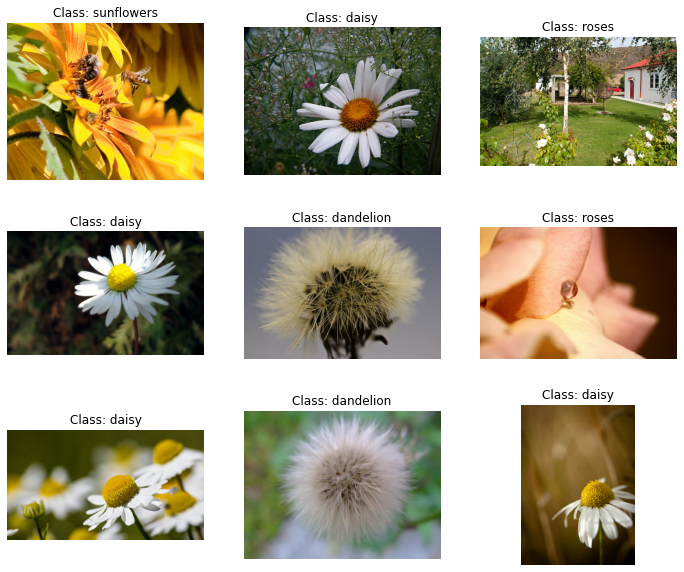

In [122]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

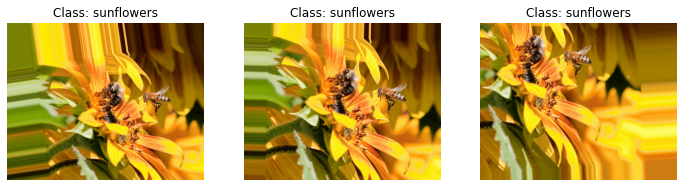

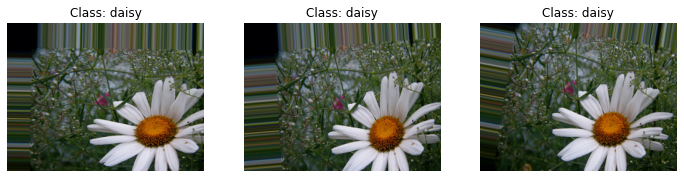

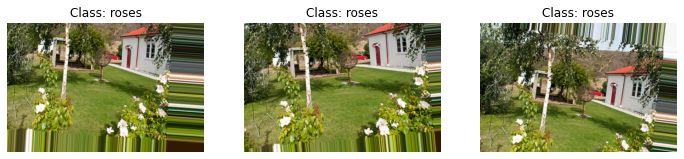

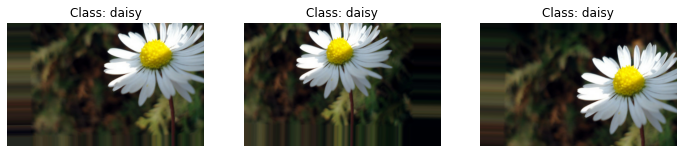

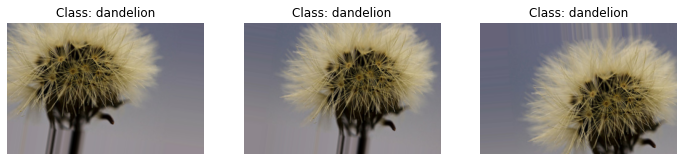

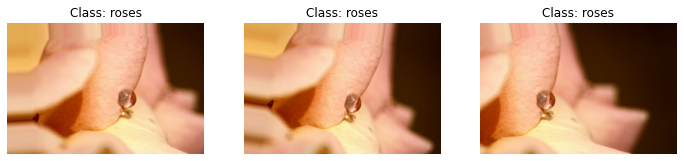

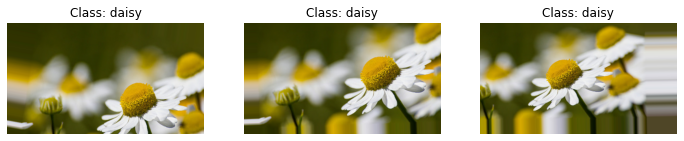

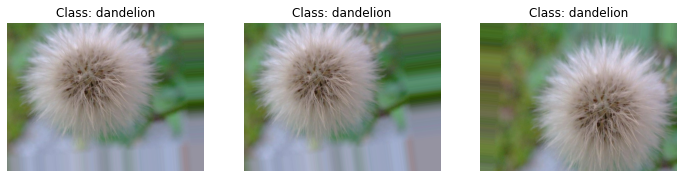

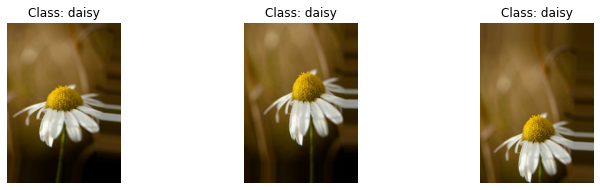

In [123]:
for image, label in train_set_raw.take(9):
    data = img_to_array(image)
    samples = expand_dims(data, 0)
    it = datagen.flow(samples, batch_size=1)
    plt.figure(figsize=(12, 10))
#     print(type(it))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        batch = it.next()
        image = batch[0].astype('uint8')
        plt.title("Class: {}".format(class_names[label]))
        plt.axis("off")
        plt.imshow(image)
# plt.show()

In [124]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 690s 8us/step


In [125]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [128]:
from functools import partial
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [129]:
for layer in base_model.layers:
    layer.trainable = False
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
86/86 [==============================] - 42s 486ms/step - loss: 0.8012 - accuracy: 0.7551 - val_loss: 2.0255 - val_accuracy: 0.7077
Epoch 2/5
86/86 [==============================] - 37s 427ms/step - loss: 0.4073 - accuracy: 0.8692 - val_loss: 1.1908 - val_accuracy: 0.7849
Epoch 3/5
86/86 [==============================] - 38s 444ms/step - loss: 0.2479 - accuracy: 0.9153 - val_loss: 1.1747 - val_accuracy: 0.7849
Epoch 4/5
86/86 [==============================] - 45s 523ms/step - loss: 0.2068 - accuracy: 0.9324 - val_loss: 1.0311 - val_accuracy: 0.7978
Epoch 5/5
86/86 [==============================] - 54s 624ms/step - loss: 0.1769 - accuracy: 0.9400 - val_loss: 1.0493 - val_accuracy: 0.7849


In [133]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Train for 86 steps, validate for 17 steps
Epoch 1/40
 1/86 [..............................] - ETA: 22:39

ResourceExhaustedError:  OOM when allocating tensor with shape[728,728,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block6_sepconv2/separable_conv2d (defined at <ipython-input-133-a6b265f99e67>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_40834]

Function call stack:
distributed_function
